### Test Generator
In this part we generate lattice (graph) and introduce X, Y, Z error using depolarization noisy model, which is more close to real world than the independent model favored by surface code.

Here we need to adjust `physical error rate` and `lattice size` to generate different case

Beware that lattice size `L` is just the width/height of grid, and L\*L is not the number of physical qubits. Instead, L\*L\*2 will be physical qubit num.

To generate `Checking matrix` to fit into `PyMatching` lib, we use special way to translate our surface code into check matrix.

In [105]:
# Parameters
# Lattice size, treat it as a square lattice
sizeX = 5
sizeY = 5

# physical error rate
p_x = 0.1
p_y = 0.1
p_z = 0.1

1. firstly let's generate lattice and add error to the qubit.

In [115]:
import random
import numpy as np
from enum import Enum
from scipy.sparse import csr_matrix

# we need encode an 2D EDGE position to 1D index in the vector
# REMEMBER: x and y start from 0 !!!
# for toric code, always use sizeX*sizeY*2 physical qubits, sizeY*2 row, each row sizeX qubits
def encode_2D_to_1D(x, y, sizeX, sizeY):
    #throw error if x or y is out of range
    if x < 0 or x >= sizeX:
        raise ValueError("x is out of range")
    if y < 0 or y >= sizeY*2:
        raise ValueError("y is out of range")
    return x + y*sizeX

def decode_1D_to_2D(index, sizeX, sizeY):
    #throw error if index is out of range
    if index < 0 or index >= sizeX*sizeY*2:
        raise ValueError("index is out of range")
    return index%sizeX, index//sizeX

def initialize_lattice(sizeX,sizeY):
    return np.zeros(sizeX*sizeY*2, dtype=int)

def introduce_errors(lattice, p_x, p_y, p_z):
    #introduce errors to the lattice
    error_x = np.zeros(len(lattice),dtype=int)
    error_z = np.zeros(len(lattice),dtype=int)
    for i in range(len(lattice)):
        rand = random.random()
        if rand < p_x:
            error_x[i] = 1
            error_z[i] = 0
        elif rand < p_x + p_y:
            error_x[i] = 1
            error_z[i] = 1
        elif rand < p_x + p_y + p_z:
            error_x[i] = 0
            error_z[i] = 1
    return error_z,error_x

2. Use surface/toric code model to detect Z and X error using star and plaquettes stablilisers seperately.

We firstly build a check_matrix, which can serve as a parity check matrix.

In [116]:
# here we set that the left and right are smooth boundary, and the bottom and top are rough boundary.
def build_check_mat_surface(sizeX,sizeY):
    pass
# use toric code, consider periodic boundary condition
def build_check_mat_toric(sizeX,sizeY):
    #first build Z star stabilizer, only odd row have star
    Z_check_matrix = []
    for y in range(1,sizeY*2,2):
        for x in range(0,sizeX):
            Z_stab = np.zeros(sizeX*sizeY*2, dtype=int)
            Z_stab[encode_2D_to_1D(x,y,sizeX,sizeY)] = \
            Z_stab[encode_2D_to_1D((x+1)%sizeX,y,sizeX,sizeY)] = \
            Z_stab[encode_2D_to_1D(x,y-1,sizeX,sizeY)] = \
            Z_stab[encode_2D_to_1D(x,(y+1)%(sizeY*2),sizeX,sizeY)] = 1
            Z_check_matrix.append(Z_stab)
    #then build X plaquetee stabilizer
    X_check_matrix = []
    for y in range(0,sizeY*2,2):
        for x in range(0,sizeX):
            X_stab = np.zeros(sizeX*sizeY*2, dtype=int)
            X_stab[encode_2D_to_1D((x-1)%sizeX,y,sizeX,sizeY)] = \
            X_stab[encode_2D_to_1D(x,y,sizeX,sizeY)] = \
            X_stab[encode_2D_to_1D(x,(y-1)%(sizeY*2),sizeX,sizeY)] = \
            X_stab[encode_2D_to_1D(x,y+1,sizeX,sizeY)] = 1
            X_check_matrix.append(X_stab)
    #use sparse matrix to save memory
    return csr_matrix(Z_check_matrix), csr_matrix(X_check_matrix)

def get_syndrome(error_lattice, check_matrix):
    #get the syndrome of the error lattice
    return check_matrix.dot(error_lattice) % 2


3. Finally write the syndrome and error lattice to file to finish the generation of testpoint.

In [134]:
def write_test_file(error_x,error_z, syndrome_X,syndrome_Z ,sizeX, filename):
    # turn the error lattice into 2D array, write it to a file
    file_content = {
        #error_x and z is for correct answer,
        "error_x":error_x.reshape(-1,sizeX),
        "error_z":error_z.reshape(-1,sizeX),
        #syndrome_x and syndrome_z is for the input of the decoder
        "syndrome_x":syndrome_X.reshape(-1,sizeX),
        "syndrome_z":syndrome_Z.reshape(-1,sizeX)
    }
    np.savez("../code/data/input/"+filename, file_content)
    return file_content

def write_result_file(consume_time,correct_x,correct_z,filename):
    file_content = {
        "time": consume_time,
        "correct_x":correct_x,
        "correct_z":correct_z
    }
    np.savez("../code/data/output/"+filename, file_content)
    return file_content


Remember that original lattice and syndromes both need writing out, because we need to visualize the logical error rate in "visualizer" part.

In [135]:
# Initialize and introduce errors
lattice = initialize_lattice(sizeX, sizeY)
# get check matrix for stabilisers
z_check_mat, x_check_mat = build_check_mat_toric(sizeX,sizeY)

# introduce error
error_z,error_x = introduce_errors(lattice, p_x, p_y, p_z)

# get syndrome
syndrome_Z = get_syndrome(error_z,z_check_mat)
syndrome_X = get_syndrome(error_x,x_check_mat)

#now make the lattice and syndrome into 2D array and save them
test_content = write_test_file(error_x,error_z, syndrome_X,syndrome_Z ,sizeX,"test1.npz")

4. Now that we have check matrix, using pymatch to generate result here.

In [130]:
# now since that check_matrix is here, use pymarching lib to get all the statistic
from pymatching import Matching
import time

#set up a timer
start_time = time.time()
# get the matching graph
decoder_result_Z = Matching(z_check_mat).decode(syndrome_Z)
decoder_result_X = Matching(x_check_mat).decode(syndrome_X)
#different syndrome simply mean different code type, like edged surface, toric.
consume_time = time.time() - start_time
print("consume time: ", consume_time)
print("decoder result Z: ", decoder_result_Z)
# write_result_file(consume_time,decoder_result_X,decoder_result_Z,"pymatch1.npz")

consume time:  0.0030012130737304688
decoder result Z:  [0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1]


In [159]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as patches

def commonconfig(sizeX,sizeY):
    plt.figure(figsize=(4, 4))
    plt.xlim(-0.5, sizeX)
    plt.ylim(-0.5, sizeY)
    #add a black point at every vertex of grid
    for y in range(sizeY):
        for x in range(sizeX):
            plt.plot(x, y, 'ko', markersize=5)  # Black dot for vertex
    ax = plt.gca()
    # Enable the grid
    ax.grid(True)
    # Hide the tick labels on both axes while keeping the grid
    ax.tick_params(axis='x', labelbottom=False)
    ax.tick_params(axis='y', labelleft=False)
    ax.set_aspect('equal', adjustable='box')  # Set aspect ratio

def plot_lattice(test_content,sizeX,sizeY):
    commonconfig(sizeX,sizeY)
    colorTable = ['k-','b-','r-','g-']
    for y in range(sizeY*2):
        for x in range(sizeX):
            result = test_content["error_x"][y,x] + test_content["error_z"][y,x]*2
            if(result == 0):
                continue
            ypos = y//2
            if(y%2 == 0):
                #it's a vertical line
                #when reach vertical boundary, draw a line that 1/2 at start and 1/2 at end
                if(y == 0):
                    plt.plot([x, x], [-0.5, 0], colorTable[result], linewidth=2)
                    plt.plot([x, x], [sizeY-0.5,sizeY], colorTable[result], linewidth=2)
                else:
                    plt.plot([x, x], [ypos-1, ypos], colorTable[result], linewidth=2)
            else:
                #it's a horizontal line
                #when reach horizontal boundary, draw a line that 1/2 at start and 1/2 at end
                if(x == 0):
                    plt.plot([-0.5, 0], [ypos, ypos], colorTable[result], linewidth=2)
                    plt.plot([sizeX-0.5, sizeX], [ypos, ypos], colorTable[result], linewidth=2)
                else:
                    plt.plot([x-1, x], [ypos, ypos], colorTable[result], linewidth=2)
                
                
    # add legend that different color line reprecent different error type
    # blue_line = mlines.Line2D([], [], color='blue', marker='o', markersize=5, label='X error')
    # green_line = mlines.Line2D([], [], color='green', marker='o', markersize=5, label='Y error')
    # red_line = mlines.Line2D([], [], color='red', marker='o', markersize=5, label='Z error')
    # plt.legend(handles=[blue_line, red_line,green_line], loc='upper right')
    plt.show()
    
def plot_syndromes_X(test_content,sizeX,sizeY):
    commonconfig(sizeX,sizeY)
    ax = plt.gca()
    for y in range(sizeY*2):
        for x in range(sizeX):
            if test_content["syndrome_x"][y,x] == 1:
                #X syndrome is a shallow blue rectangle that fill the lattice
                ax.add_patch(patches.Rectangle((x-0.5, y//2-0.5), 1, 1, edgecolor='blue', facecolor='none'))
    plt.show()

def plot_syndromes_Z(test_content,sizeX,sizeY):
    commonconfig(sizeX,sizeY)
    for y in range(sizeY*2):
        for x in range(sizeX):
            if test_content["syndrome_z"][y,x] == 1:
                #Z syndrome is on the vertice, show as a red star point
                if(y%2 == 0):
                    #it's a vertical line
                    plt.plot(x, y//2, 'r*', markersize=7)  # Red star for Z syndrome on vertex

    plt.show()


Lattice with errors:
[[0 0 1 0 1]
 [0 1 0 0 0]
 [0 1 0 0 1]
 [1 0 0 1 1]
 [0 0 1 0 1]
 [1 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [1 0 1 0 1]]


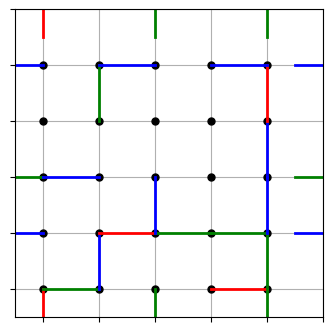

X Syndromes:


IndexError: index 5 is out of bounds for axis 0 with size 5

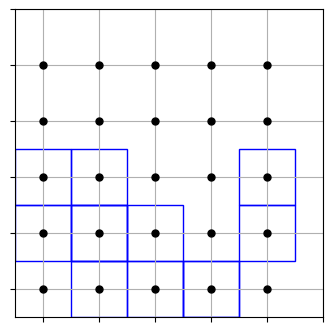

In [160]:

print("Lattice with errors:")
print(test_content["error_x"])
plot_lattice(test_content,sizeX,sizeY)

print("X Syndromes:")
plot_syndromes_X(test_content,sizeX,sizeY)

print("Z Syndromes:")
plot_syndromes_Z(test_content,sizeX,sizeY)